In [130]:
import sys, os
sys.path.append("C:/users/kristijan/documents/projects/jhu1/")
sys.path.append("C:/users/kristijan/documents/projects/jhu1/data")
sys.path.append("C:/users/kristijan/documents/projects/jhu1/output")
os.chdir("C:/users/kristijan/documents/projects/jhu1/")
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
sns.set(font_scale=1.3)
from matplotlib import pyplot as plt
from stimuli import prefixes, prompts
import json

# GPT-2 incongruent probe

First, I load in the outputs.
These are the outputs of the script `run_gpt2_surprisal_scripts.sh`

In [131]:
# file naming syntax:
# metric_model_scenario_condition_list-type
files_gpt = [
    "surprisal_gpt2_sce1rnd_permute_categorized.csv",
    "surprisal_gpt2_sce1rnd_repeat_categorized.csv",
    "surprisal_gpt2_sce1rnd_control_categorized.csv",
    "surprisal_gpt2_sce1rnd_permute_random.csv",
    "surprisal_gpt2_sce1rnd_repeat_random.csv",
    "surprisal_gpt2_sce1rnd_control_random.csv",
    "surprisal_gpt2_sce1_permute_categorized.csv",
    "surprisal_gpt2_sce1_repeat_categorized.csv",
    "surprisal_gpt2_sce1_control_categorized.csv",
    "surprisal_gpt2_sce1_permute_random.csv",
    "surprisal_gpt2_sce1_repeat_random.csv",
    "surprisal_gpt2_sce1_control_random.csv"
]

In [132]:
# load output .csvs in a loop, then concatenate them
dfs = []
for file in files_gpt:
    dftmp = pd.read_csv(os.path.join("./output", file), header=0)
    
    # add information from filenames
    dftmp["list"] = file.split("_")[-1].split(".")[0]  # add column on list composition
    dftmp["second_list"] = file.split("_")[-2]         # store information on second list
    dftmp["scenario"] = file.split("_")[-3]
    
    # remove punctuation prior to creating token index
    # filter out punctuation
    dftmp = dftmp.loc[~dftmp.ispunct, :]
    
    # add "sentpos" column containing token index within a sentence
    tmp = []
    for sentid in dftmp.stimID.unique():
        tmp.append(np.arange(0, len(dftmp.loc[dftmp.stimID==sentid, "stimID"])))
    dftmp["sentpos"] = np.concatenate(tmp)
    tmp = None  # clear variable
    
    dfs.append(dftmp)
gpt = pd.concat(dfs)

# clear some variables for memory
dfs = None
dftmp = None
del dfs

In [133]:
# let's also rename some columns
gpt.rename(columns={"Unnamed: 0": "index_orig", "trialID" : "marker", "prompt": "prompt_len"}, inplace=True)

## Checking inputs

Well-formed prompt:

In [134]:
stimulus_id = 92 # let's pick a trial
selection = ((gpt.stimID==stimulus_id) & (gpt.second_list=="permute") & (gpt.list=="random") & (gpt.scenario=="sce1"))
for i in range(4):
    print("{}: ".format(i) + " ".join(gpt.loc[(gpt.marker == i) & selection].token.tolist()).strip())

0: Before  the  meeting  Mary  wrote  down  the  following  list  of  words
1: farmer  contest  outline  success  orange
2: After  the  meeting  Mary  went  for  a  walk  It  was  a  busy  day  and  she  needed  a  break  Outside  was  really  beautiful  and  warm  and  the  flowers  in  the  park  were  blo oming  When  she  got  back  she  read  the  list  again
3: success  outline  contest  farmer  orange


Permuted prompt and the target list is a control:

In [135]:
selection = ((gpt.stimID==stimulus_id) & (gpt.second_list=="control") & (gpt.list=="random") & (gpt.scenario=="sce1rnd"))
for i in range(4):
    print("{}: ".format(i) + " ".join(gpt.loc[(gpt.marker == i) & selection].token.tolist()).strip())

0: Before  the  meeting  Mary  wrote  down  the  following  list  of  words
1: farmer  contest  outline  success  orange
2: the  back  in  for  and  were  a  When  she  walk  was  meeting  Outside  break  the  got  warm  went  and  After  Mary  the  read  list  park  beautiful  again  really  a  a  needed  It  busy  was  she  and  she  day  the  flowers  blo oming
3: eagle  needle  union  st anza  begg ar


## Averaging and grouping

Now, let's rely on built-in pandas toolkit to compute the means.
First, I group/split trials by all the possible variables and compute average surprisal for each split.

In [136]:
t = None
# average per word list, separately for list len, prompt type, list composition and second list type
levels = ["scenario", "prompt_len", "list_len", "list", "second_list", "stimID", "marker"]
t = gpt.groupby(levels) \
       .agg({"surp": ["mean", "std"], "token": len, "token": list}) \
       .reset_index()                                               

In [137]:
# rename columns
t.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in t.columns.values]

Let's check the frame

In [138]:
t.head()

,scenario,prompt_len,list_len,list,second_list,stimID,marker,surp_mean,surp_std,token_list
0,sce1,1,3,categorized,control,1,0,4.315525,2.486507,"[Before, the, meeting, Mary, wrote, down,..."
1,sce1,1,3,categorized,control,1,1,7.498307,4.942518,"[ window, door, roof]"
2,sce1,1,3,categorized,control,1,2,3.015319,3.508526,"[After, the, meeting, Mary, read, the, l..."
3,sce1,1,3,categorized,control,1,3,6.264711,4.631768,"[ salt, pepper, sugar]"
4,sce1,1,3,categorized,control,2,0,4.315525,2.486507,"[Before, the, meeting, Mary, wrote, down,..."


## Relative to length-matched list in the same position

In [139]:
data = None
data = t.loc[(t.marker == 3), :]  # we only look at the target word list which is coded as '3'

## Random lists

In [140]:
# now subtract average surprisal from permute and repeat conditions
list_type="random"
scenario="sce1"
selection = (data.list == list_type) & (data.scenario  == scenario)
control = data.loc[(selection) & (data.second_list == "control")].copy()
repeat = data.loc[(selection) & (data.second_list == "repeat")].copy()
permute = data.loc[(selection) & (data.second_list == "permute")].copy()

In [141]:
repeat["surp_rel"] = repeat.surp_mean.to_numpy()/control.surp_mean.to_numpy()
permute["surp_rel"] = permute.surp_mean.to_numpy()/control.surp_mean.to_numpy()

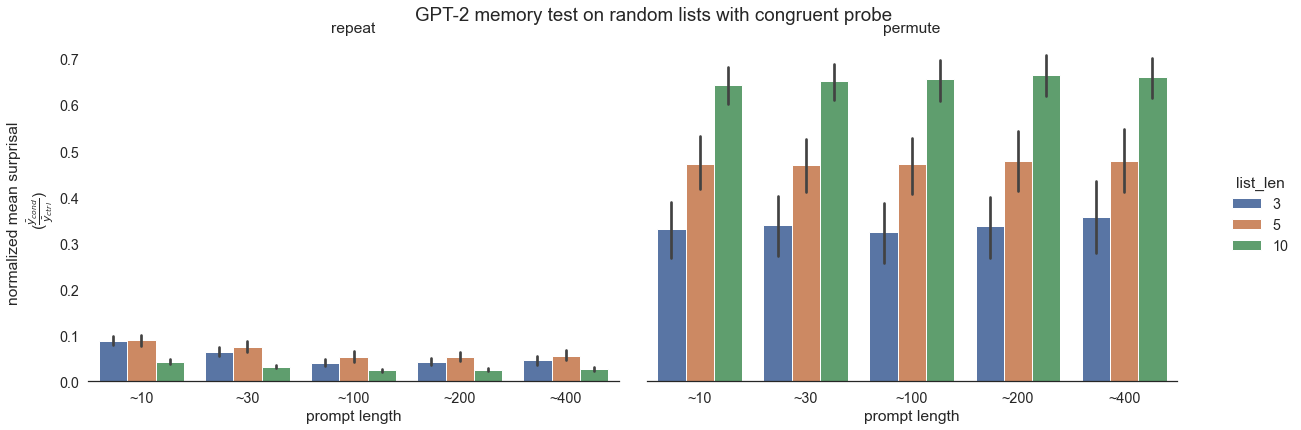

In [142]:
sns.set_style("white")
g=sns.catplot(kind="bar", data=pd.concat([repeat, permute]), x="prompt_len", y="surp_rel", estimator=np.mean, ci=95.0, hue="list_len", col="second_list")
g.fig.set_size_inches(18,6)
g.fig.suptitle("GPT-2 memory test on random lists with congruent probe")
(g.set_axis_labels("prompt length", "normalized mean surprisal \n($\\frac{\\bar{y}_{cond}}{\\bar{y}_{ctrl}}$)")
  .set_xticklabels(["~10", "~30", "~100", "~200", "~400"])
  .set_titles("{col_name}")
  .despine(left=True))
#plt.savefig("./figures/eda_09-02-2021/relsurp_gpt2_{}_{}.png".format(scenario, list_type))

### Random list, incongruent probe

In [143]:
# now subtract average surprisal from permute and repeat conditions
list_type = "random"
scenario = "sce1rnd"
selection = (data.list == list_type) & (data.scenario  == scenario)
control = data.loc[(selection) & (data.second_list == "control")].copy()
repeat = data.loc[(selection) & (data.second_list == "repeat")].copy()
permute = data.loc[(selection) & (data.second_list == "permute")].copy()

In [144]:
repeat["surp_rel"] = repeat.surp_mean.to_numpy()/control.surp_mean.to_numpy()
permute["surp_rel"] = permute.surp_mean.to_numpy()/control.surp_mean.to_numpy()

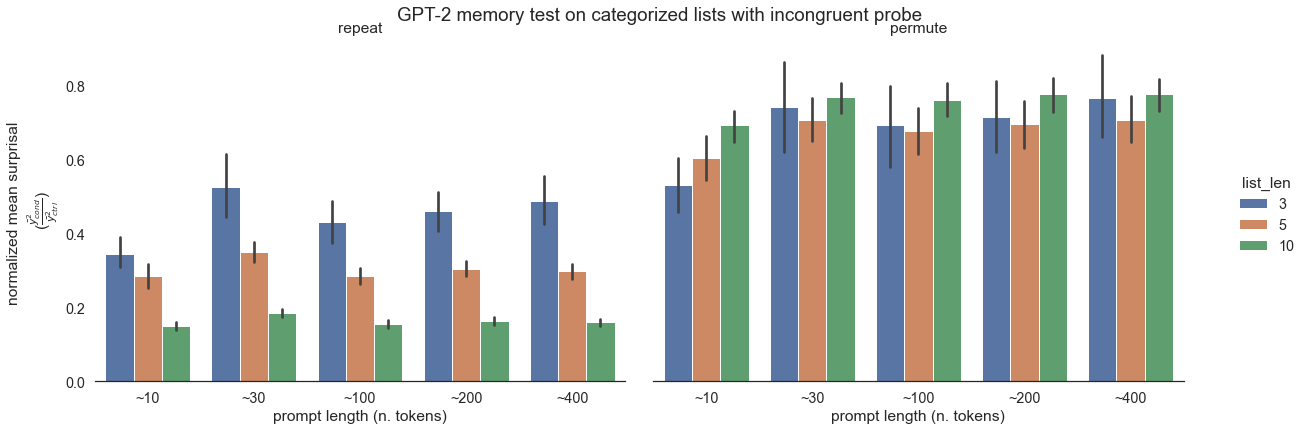

In [145]:
g=sns.catplot(kind="bar", data=pd.concat([repeat, permute]), estimator=np.mean, ci=95.0, x="prompt_len", y="surp_rel", hue="list_len", col="second_list")
g.fig.set_size_inches(18,6)
g.fig.suptitle("GPT-2 memory test on categorized lists with incongruent probe")
(g.set_axis_labels("prompt length (n. tokens)", "normalized mean surprisal \n($\\frac{\\bar{y}^{2}_{cond}}{\\bar{y}^{2}_{ctrl}}$)")
  .set_xticklabels(["~10", "~30", "~100", "~200", "~400"])
  .set_titles("{col_name}")
  .despine(left=True))
# plt.savefig("./figures/eda_09-02-2021/relsurp_gpt2_{}_{}.png".format(scenario, list_type))
data, control, permute, repeat = None, None, None, None

## Compute averages over first three tokens

In [146]:
t = None
# average per word list, separately for list len, prompt type, list composition and second list type
levels = ["scenario", "prompt_len", "list_len", "list", "second_list", "stimID", "marker"]

# drop onset tokens, take tokens belonging to target list, then average
selection = (gpt.positionID.isin([0, 2, 4])) & (gpt.marker == 3)

t = gpt.loc[selection].groupby(levels) \
                      .agg({"surp": ["mean", "std"], "token": len, "token": list}) \
                      .reset_index()  

# rename columns
t.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in t.columns.values]

Let's check that all is good. We can see that "token list" column shows one fewer token than before:

In [147]:
t.head(5)

,scenario,prompt_len,list_len,list,second_list,stimID,marker,surp_mean,surp_std,token_list
0,sce1,1,3,categorized,control,1,3,6.264711,4.631768,"[ salt, pepper, sugar]"
1,sce1,1,3,categorized,control,2,3,4.201801,3.849356,"[ blue, red, green]"
2,sce1,1,3,categorized,control,3,3,6.533674,1.836867,"[ log, cat, horse]"
3,sce1,1,3,categorized,control,4,3,5.133392,2.590517,"[ murder, rape, robbery]"
4,sce1,1,3,categorized,control,5,3,5.891810,2.965146,"[ mountain, hill, valley]"


In [148]:
t.tail(5)

,scenario,prompt_len,list_len,list,second_list,stimID,marker,surp_mean,surp_std,token_list
3595,sce1rnd,5,10,random,repeat,296,3,4.065164,5.581905,"[ witness, squirrel, castle]"
3596,sce1rnd,5,10,random,repeat,297,3,4.860854,4.625681,"[ window, feature, unit]"
3597,sce1rnd,5,10,random,repeat,298,3,5.595566,6.413705,"[ captive, merit, despair]"
3598,sce1rnd,5,10,random,repeat,299,3,4.674847,4.582446,"[ million, pigeon, career]"
3599,sce1rnd,5,10,random,repeat,300,3,4.762969,5.599032,"[ column, crystal, duty]"


In [149]:
data = None
data = t.copy()  # we only look at the target word list which is coded as '3'

In [150]:
# now subtract average surprisal from permute and repeat conditions
list_type="random"
scenario="sce1rnd"
selection = (data.list == list_type) & (data.scenario  == scenario)
control = data.loc[(selection) & (data.second_list == "control")].copy()
repeat = data.loc[(selection) & (data.second_list == "repeat")].copy()
permute = data.loc[(selection) & (data.second_list == "permute")].copy()

In [151]:
repeat["surp_rel"] = repeat.surp_mean.to_numpy()/control.surp_mean.to_numpy()
permute["surp_rel"] = permute.surp_mean.to_numpy()/control.surp_mean.to_numpy()

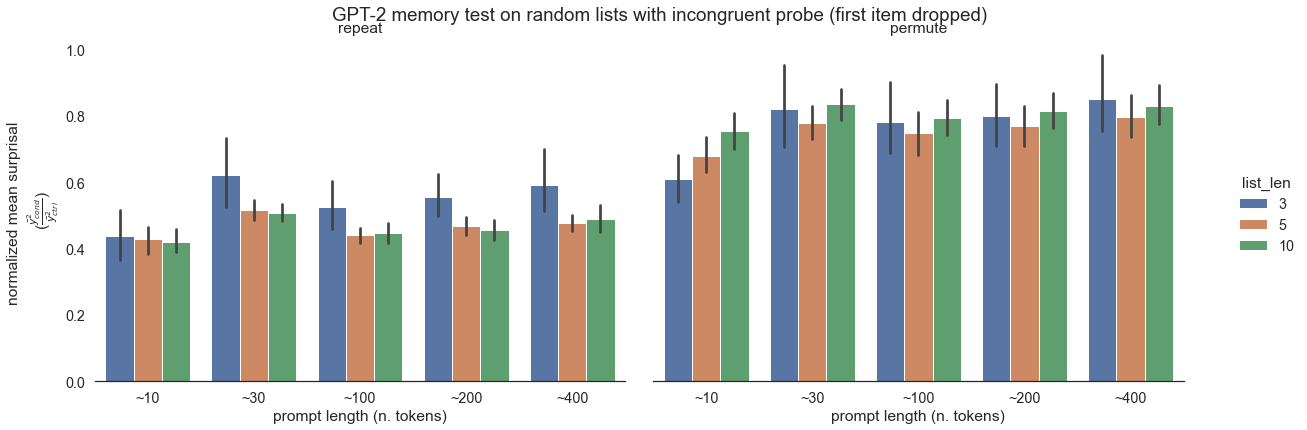

In [152]:
g = sns.catplot(kind="bar", data=pd.concat([repeat, permute]), estimator=np.mean, ci=95.0, x="prompt_len", y="surp_rel", hue="list_len", col="second_list")
g.fig.set_size_inches(18,6)
g.fig.suptitle("GPT-2 memory test on random lists with incongruent probe (first item dropped)")
(g.set_axis_labels("prompt length (n. tokens)", "normalized mean surprisal \n($\\frac{\\bar{y}^{2}_{cond}}{\\bar{y}^{2}_{ctrl}}$)")
  .set_xticklabels(["~10", "~30", "~100", "~200", "~400"])
  .set_titles("{col_name}")
  .despine(left=True))
# plt.savefig("./figures/eda_09-02-2021/relsurp_gpt2_{}_{}.png".format(scenario, list_type))
# data, control, permute, repeat = None, None, None, Noneb

In [153]:
data = None
selection = (gpt.marker==3)
data = gpt.loc[selection].copy()# create new x-axis token indices (now that punctuation is off)


In [154]:
sel = (data.list_len==10) & (data.scenario=="sce1rnd") & (data.list=="random") & (data.prompt_len==1)
m=[]
y=data.loc[sel].copy()

for c in y.second_list.unique():
    tmp=[]
    for s in y.stimID.unique():
        tmp.append(y.loc[(y.stimID==s) & (y.second_list==c)].surp)
    m.append(tmp)

In [155]:
my=[]
for j in range(len(m)):
    y2 = np.full(shape=(len(m[j]), max([len(e) for e in m[j]])), fill_value=np.nan)
    for i in range(len(m[j])):
        y2[i, 0:len(m[j][i])] = m[j][i]
    my.append(y2)

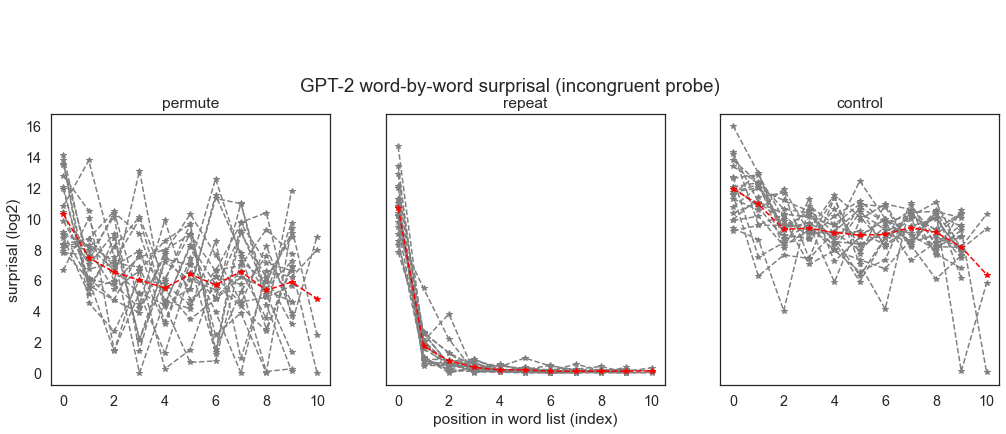

In [156]:
fig, ax = plt.subplots(1, 3, sharex="all", sharey="all", figsize=(17, 5))
for i in range(len(ax)):
    x=np.arange(0, my[i].shape[1])
    ax[i].plot(x, my[i].T, color="gray", marker="*", linestyle="--")
    ax[i].plot(x, np.nanmean(my[i].T, axis=1), color="red", marker="*", linestyle="--")
    ax[i].set_title(y.second_list.unique()[i])
    
    if i==0:
        ax[i].set_ylabel("surprisal (log2)")
    if i==1:
        ax[i].set_xlabel("position in word list (index)")
    if i==2:
        ax[i].annotate(xy=(6, 22), text="N = 20\nred = mean")
    
fig.suptitle("GPT-2 word-by-word surprisal (incongruent probe)")
plt.show()

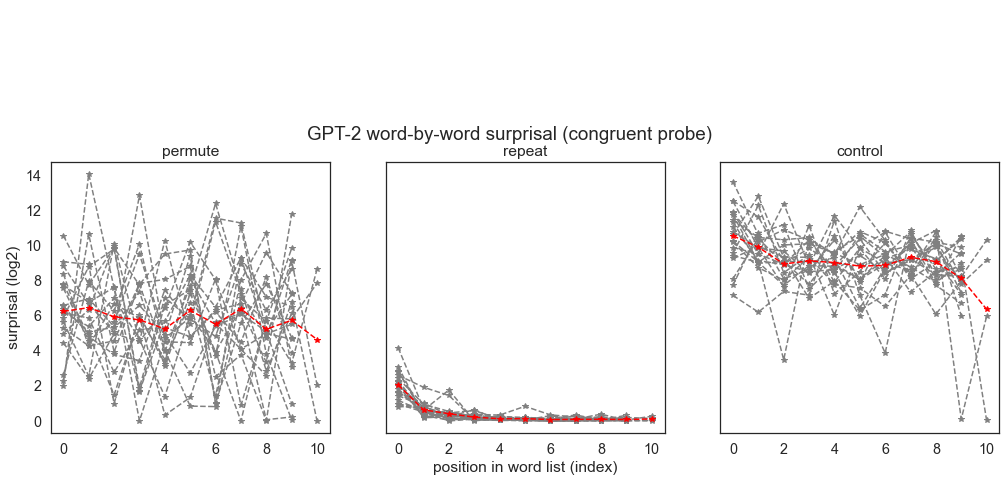

In [157]:
data = None
selection = (gpt.marker==3)
data = gpt.loc[selection].copy()# create new x-axis token indices (now that punctuation is off)
sel = (data.list_len==10) & (data.scenario=="sce1") & (data.list=="random") & (data.prompt_len==1)
m=[]
y=data.loc[sel].copy()

for c in y.second_list.unique():
    tmp=[]
    for s in y.stimID.unique():
        tmp.append(y.loc[(y.stimID==s) & (y.second_list==c)].surp)
    m.append(tmp)

my=[]
for j in range(len(m)):
    y2 = np.full(shape=(len(m[j]), max([len(e) for e in m[j]])), fill_value=np.nan)
    for i in range(len(m[j])):
        y2[i, 0:len(m[j][i])] = m[j][i]
    my.append(y2)    

fig, ax = plt.subplots(1, 3, sharex="all", sharey="all", figsize=(17, 5))
for i in range(len(ax)):
    x=np.arange(0, my[i].shape[1])
    ax[i].plot(x, my[i].T, color="gray", marker="*", linestyle="--")
    ax[i].plot(x, np.nanmean(my[i].T, axis=1), color="red", marker="*", linestyle="--")
    ax[i].set_title(y.second_list.unique()[i])
    
    if i==0:
        ax[i].set_ylabel("surprisal (log2)")
    if i==1:
        ax[i].set_xlabel("position in word list (index)")
    if i==2:
        ax[i].annotate(xy=(6, 22), text="N = 20\nred = mean")
    
fig.suptitle("GPT-2 word-by-word surprisal (congruent probe)")
plt.show()

# RNN

In [216]:
files_rnn = [
    "surprisal_rnn_sce1_permute_categorized.csv",
    "surprisal_rnn_sce1_repeat_categorized.csv",
    "surprisal_rnn_sce1_permute_random.csv",
    "surprisal_rnn_sce1_repeat_random.csv",
    "surprisal_rnn_sce1_control_categorized.csv",
    "surprisal_rnn_sce1_control_random.csv",
    "surprisal_rnn_sce1rnd_permute_categorized.csv",
    "surprisal_rnn_sce1rnd_repeat_categorized.csv",
    "surprisal_rnn_sce1rnd_permute_random.csv",
    "surprisal_rnn_sce1rnd_repeat_random.csv",
    "surprisal_rnn_sce1rnd_control_categorized.csv",
    "surprisal_rnn_sce1rnd_control_random.csv",
]
def load_csv(files):
    dfs = []
    for file in files:
        dftmp = pd.read_csv(os.path.join("./output", file), sep="\t", header=0)
        dftmp["list"] = file.split("_")[-1].split(".")[0]  # add column on list composition
        dftmp["second_list"] = file.split("_")[-2]
        dftmp["scenario"] = file.split("_")[-3]
        
        dftmp = dftmp.loc[~dftmp.word.isin([":", ".", ","])].copy()
        # create
        a = []
        for s in dftmp.sentid.unique():
            t = dftmp.loc[dftmp.sentid==s]
            for m in t.marker.unique():
                a.append(np.arange(0, len(t.loc[t.marker==m])))
        dftmp["marker_pos"] = np.concatenate(a)
        
        dfs.append(dftmp)
    df = pd.concat(dfs)
    dfs=None
    del dfs
    
    return df

rnn = load_csv(files_rnn)

In [218]:
# fix data types
rnn.list_len = rnn.list_len.astype(int)

Well-formed prompt

In [161]:
selection = ((rnn.sentid==91) & (rnn.second_list=="permute") & (rnn.list=="random") & (rnn.scenario=="sce1"))
for i in range(4):
    print("{}:".format(i) + " ".join(rnn.loc[(rnn.marker == i) & selection].word.tolist()))

0:before the meeting <unk> wrote down the following list of words
1:farmer contest outline success orange
2:after the meeting <unk> went for a walk it was a busy day and she needed a break outside was really beautiful and warm and the flowers in the park were blooming when she got back she read the list again
3:success outline contest farmer orange


Permuted prompt

In [162]:
selection = ((rnn.sentid==91) & (rnn.second_list=="control") & (rnn.list=="random") & (rnn.scenario=="sce1rnd"))
for i in range(4):
    print("{}:".format(i) + " ".join(rnn.loc[(rnn.marker == i) & selection].word.tolist()))

0:before the meeting <unk> wrote down the following list of words
1:farmer contest outline success orange
2:the back in for and were a when she walk was meeting outside break the got warm went and after <unk> the read list park beautiful again really a a needed it busy was she and she day the flowers blooming
3:eagle needle union stanza beggar


In [163]:
d = None
# average per word list, separately for list len, prompt type, list composition and second list type
d = rnn.groupby(["sentid", "prompt_len", "list_len", "marker", "list", "second_list", "scenario"]) \
       .agg({"surp": ["mean", "std"], "word": len, "word": list}) \
       .reset_index()

In [164]:
d.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in d.columns.values]

### Random lists, congruent probe

In [165]:
data = None
data = d.loc[(d.marker == 3), :]  # select second presentation of the word list

In [166]:
# now subtract average surprisal from permute and repeat conditions
list_type = "random"
scenario = "sce1"
selection = (data.list == list_type) & (data.scenario == scenario)
control = data.loc[(selection) & (data.second_list == "control")].copy()
repeat = data.loc[(selection) & (data.second_list == "repeat")].copy()
permute = data.loc[(selection) & (data.second_list == "permute")].copy()

In [167]:
repeat["surp_rel"] = repeat.surp_mean.to_numpy()/control.surp_mean.to_numpy()
permute["surp_rel"] = permute.surp_mean.to_numpy()/control.surp_mean.to_numpy()

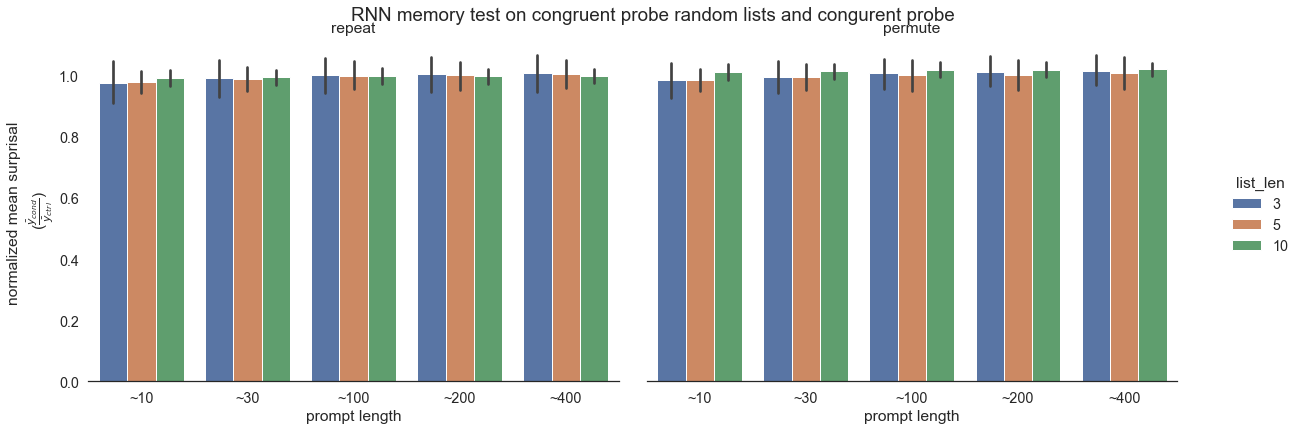

In [168]:
g=sns.catplot(kind="bar", data=pd.concat([repeat, permute]), estimator=np.mean, ci=95.0, x="prompt_len", y="surp_rel", hue="list_len", col="second_list")
g.fig.set_size_inches(18,6)
g.fig.suptitle("RNN memory test on congruent probe random lists and congurent probe")
(g.set_axis_labels("prompt length", "normalized mean surprisal \n($\\frac{\\bar{y}_{cond}}{\\bar{y}_{ctrl}}$)")
  .set_xticklabels(["~10", "~30", "~100", "~200", "~400"])
  .set_titles("{col_name}")
  .despine(left=True))
#plt.savefig("./figures/eda_09-02-2021/relsurp_rnn_{}_{}.png".format(scenario, list_type))

### Random list, incongruent probe

In [169]:
# now subtract average surprisal from permute and repeat conditions
list_type = "random"
scenario = "sce1rnd"
selection = (data.list == list_type) & (data.scenario == scenario)
control = data.loc[(selection) & (data.second_list == "control")].copy()
repeat = data.loc[(selection) & (data.second_list == "repeat")].copy()
permute = data.loc[(selection) & (data.second_list == "permute")].copy()

In [170]:
# create a column which contains condition/control
repeat["surp_rel"] = repeat.surp_mean.to_numpy()/control.surp_mean.to_numpy()
permute["surp_rel"] = permute.surp_mean.to_numpy()/control.surp_mean.to_numpy()

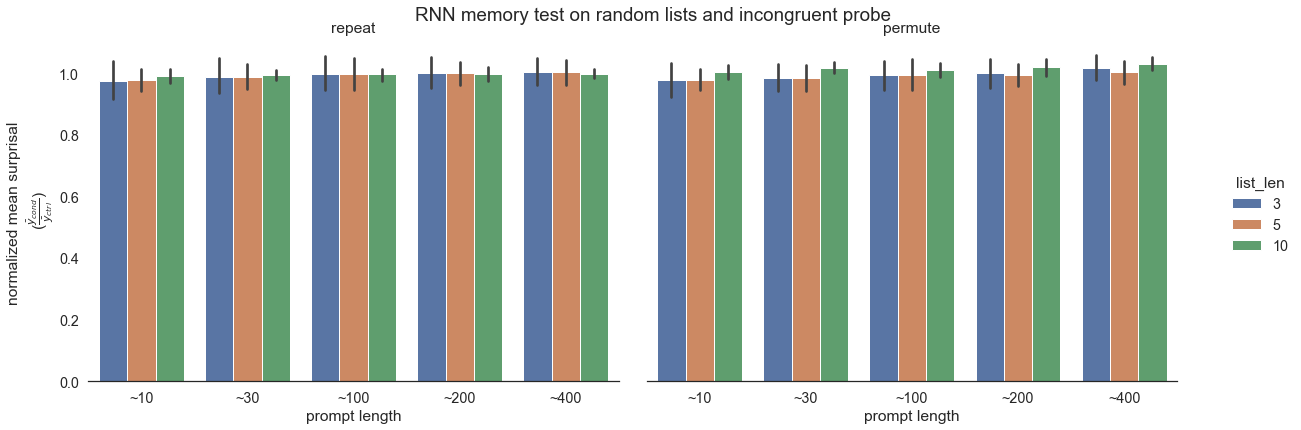

In [171]:
g2=sns.catplot(kind="bar", data=pd.concat([repeat, permute]), estimator=np.mean, ci=95.0, x="prompt_len", y="surp_rel", hue="list_len", col="second_list")
g2.fig.set_size_inches(18,6)
g2.fig.suptitle("RNN memory test on random lists and incongruent probe")
(g2.set_axis_labels("prompt length", "normalized mean surprisal \n($\\frac{\\bar{y}_{cond}}{\\bar{y}_{ctrl}}$)")
  .set_xticklabels(["~10", "~30", "~100", "~200", "~400"])
  .set_titles("{col_name}")
  .despine(left=True))
#plt.savefig("./figures/eda_09-02-2021/relsurp_rnn_{}_{}.png".format(scenario, list_type))

In [172]:
def plot_surp(df, title):
    m=[]
    for c in df.second_list.unique():
        tmp=[]
        for s in df.sentid.unique():
            tmp.append(df.loc[(df.sentid==s) & (df.second_list==c)].surp)
        m.append(tmp)

    my=[]
    for j in range(len(m)):
        y2 = np.full(shape=(len(m[j]), max([len(e) for e in m[j]])), fill_value=np.nan)
        for i in range(len(m[j])):
            y2[i, 0:len(m[j][i])] = m[j][i]
        my.append(y2)
    
    fig, ax = plt.subplots(1, 3, sharex="all", sharey="all", figsize=(17, 5))
    for i in range(len(ax)):
        x=np.arange(0, my[i].shape[1])
        ax[i].plot(x, my[i].T, color="gray", linestyle="-")
        ax[i].plot(x, np.nanmean(my[i].T, axis=1), color="red", marker="*", linestyle="--")
        ax[i].set_title(df.second_list.unique()[i])
        if i==0:
            ax[i].set_ylabel("surprisal (log2)")
        if i==1:
            ax[i].set_xlabel("position in word list (index)")
        if i==2:
            ax[i].annotate(xy=(6, 22), text="N = 20\nred = mean")

    fig.suptitle(title)
    plt.ylim([0, plt.ylim()[1]])
    plt.tight_layout()
    plt.show()

In [173]:
data = None
selection = (rnn.marker==3)
data = rnn.loc[selection].copy()# create new x-axis token indices (now that punctuation is off)

In [174]:
scenario="sce1rnd"
list_type="random"
prompt_len=3
list_len=10
sel = (data.list_len==list_len) & (data.scenario==scenario) & (data.list==list_type) & (data.prompt_len==prompt_len)
y=data.loc[sel].copy()

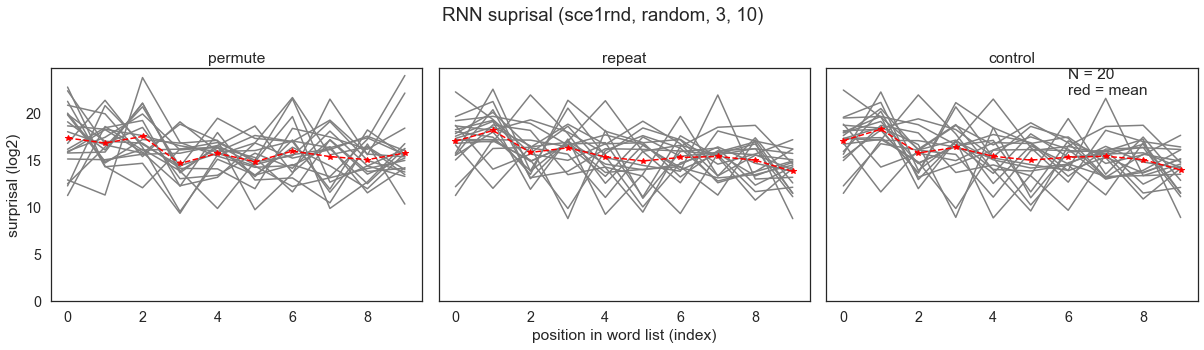

In [175]:
plot_surp(y, title="RNN suprisal ({}, {}, {}, {})".format(scenario, list_type, prompt_len, list_len))

In [176]:
data = None
selection = (rnn.marker==3)
data = rnn.loc[selection].copy()# create new x-axis token indices (now that punctuation is off)
scenario="sce1"
list_type="random"
prompt_len=3
list_len=10
sel = (data.list_len==list_len) & (data.scenario==scenario) & (data.list==list_type) & (data.prompt_len==prompt_len)
y=data.loc[sel].copy()

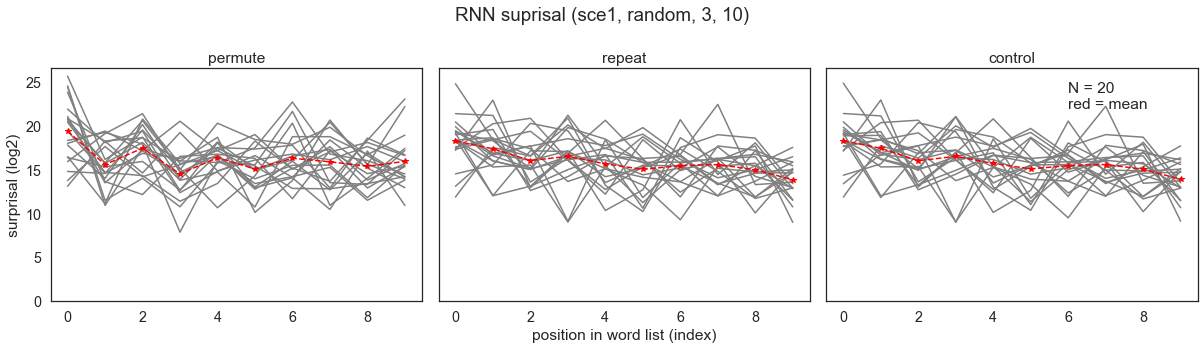

In [177]:
plot_surp(y, title="RNN suprisal ({}, {}, {}, {})".format(scenario, list_type, prompt_len, list_len))

In [178]:
sel = (data.list_len==list_len) & (data.scenario==scenario) & (data.list=="random") & (data.prompt_len==prompt_len)
data.loc[sel & (data.second_list=="repeat"), ["second_list", "list", "sentid", "word", "surp"]].head(10)

,second_list,list,sentid,word,surp
13563,repeat,random,160,language,17.255144
13565,repeat,random,160,sparrow,22.985458
13567,repeat,random,160,laughter,12.990361
13569,repeat,random,160,bottom,16.941399
13571,repeat,random,160,mayor,20.684328
13573,repeat,random,160,garment,16.305820
13575,repeat,random,160,summer,11.928377
13577,repeat,random,160,armor,17.753105
13579,repeat,random,160,status,17.260662
13581,repeat,random,160,bedroom,15.491512


In [179]:
sel = (data.list_len==list_len) & (data.scenario==scenario) & (data.list=="random") & (data.prompt_len==prompt_len)
data.loc[sel & (data.second_list=="permute"), ["second_list", "list", "sentid", "word", "surp"]].head(10)

,second_list,list,sentid,word,surp
13563,permute,random,160,armor,24.531925
13565,permute,random,160,laughter,10.960879
13567,permute,random,160,bottom,17.497934
13569,permute,random,160,bedroom,16.023697
13571,permute,random,160,status,18.740028
13573,permute,random,160,language,10.162683
13575,permute,random,160,summer,13.802495
13577,permute,random,160,mayor,20.718615
13579,permute,random,160,garment,15.588365
13581,permute,random,160,sparrow,22.258125


In [180]:
sel = (data.list_len==list_len) & (data.scenario==scenario) & (data.list=="random") & (data.prompt_len==prompt_len)
data.loc[sel & (data.second_list=="control"), ["second_list", "list", "sentid", "word", "surp"]].head(10)

,second_list,list,sentid,word,surp
13563,control,random,160,column,17.706760
13565,control,random,160,crystal,18.437031
13567,control,random,160,duty,19.252026
13569,control,random,160,aspect,16.169247
13571,control,random,160,paper,12.408977
13573,control,random,160,insect,18.635485
13575,control,random,160,tiger,14.759419
13577,control,random,160,daylight,16.112223
13579,control,random,160,receipt,15.709664
13581,control,random,160,pocket,12.941529


In [226]:
data=None
data=rnn.loc[(rnn.marker==3) & (rnn.list_len==5)]

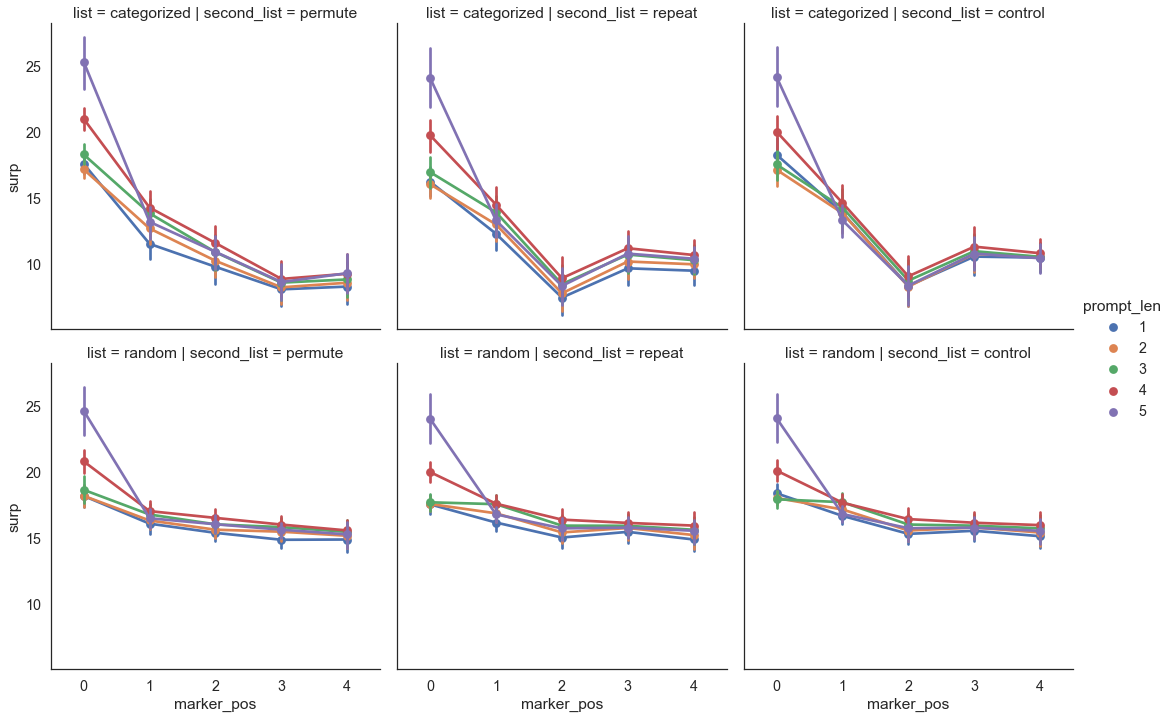

In [227]:
sns.catplot(data=data, kind="point", x="marker_pos", y="surp", hue="prompt_len", col="second_list", row="list")